In [1]:
import sys
from pathlib import Path

# Add the path to the utils folder to sys.path
utils_path = Path('../python').resolve()
print(utils_path)
sys.path.append(str(utils_path))

from pathlib import Path
from rasterio.crs import CRS
from crop_utils import (crop_image_by_coordinates, 
                        crop_image_by_geojson_shp, 
                        reproject_geotiff)
from edit_path_utils import (edit_paths)

import rasterio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from process_utils import (preprocess_data,
                           superpixel_segmentation,
                            tv_denoise, 
                            preprocess_for_merge)
from rio_utils import (reproject_arr_to_match_profile)

/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/Alpha_Code/wildfire_new/uavsar-main/python


In [2]:
shp_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_shape/Ca")
# shps = sorted(list(shp_dir.glob('./*.shp')))
shps = sorted([shp for shp in shp_dir.glob('*.shp') if not shp.name.startswith('._')])
shps

[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_shape/Ca/ca3424811795920200906_20200703_20210706_burn_bndy.shp'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_shape/Ca/ca3424811795920200906_20200703_20210706_mask.shp')]

In [3]:
##shps = '../data/bobcat/uavsar_perimeter/bobcat_perimeter_bilinear_inc_south.geojson'
shps = '/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_shape/Ca/ca3424811795920200906_20200703_20210706_burn_bndy.shp'
shps

'/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Bobcat_shape/Ca/ca3424811795920200906_20200703_20210706_burn_bndy.shp'

In [4]:
# data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_data")
# # tifs = sorted(list(data_dir.glob('./*weighted*.tif')))
# # tifs = sorted(list(data_dir.glob('*.tif')))
# tifs = sorted([tif for tif in data_dir.glob('*_alpha1.tif') if not tif.name.startswith('._')])

# tifs

In [5]:
# path_to_polygon_file = shps
# path_to_images = tifs
# output_names = [str(data_dir) + '/' + file.stem + '_perimeter_crop.tif' for file in tifs]
# output_names



In [6]:
# for i in range(len(path_to_images)):
#     crop_image_by_geojson_shp(path_to_polygon_file,
#                               path_to_images[i], 
#                               output_names[i])

In [7]:
# # Iterate through all files and display each raster
# for file_path in output_names:
#     with rasterio.open(file_path) as src:
#         data = src.read()

#     if data.shape[0] == 1:
#         data = np.squeeze(data, axis=0)

#     plt.figure(figsize=(10, 10))
#     plt.imshow(data, cmap='viridis')  # Use 'gray' for grayscale view
#     plt.axis('off')
#     plt.title(f'Raster Image: {file_path.split("\\")[-1]}')
#     plt.show()

In [8]:
# fig, axes = plt.subplots(2, 2, figsize=(20, 20))  # 2x2 grid
# axes = axes.flatten()  # Flatten to easily loop through

# for idx, file_path in enumerate(output_names):
#     with rasterio.open(file_path) as src:
#         data = src.read()

#     if data.shape[0] == 1:
#         data = np.squeeze(data, axis=0)

#     axes[idx].imshow(data, cmap='viridis')
#     axes[idx].axis('off')
#     axes[idx].set_title(file_path.split("\\")[-1], fontsize=10)

# plt.tight_layout()
# plt.show()

In [9]:
# # This is needed to open raster files

# # Replace with your actual raster file path
# file_path = output_names[0]

# # Open the raster file
# with rasterio.open(file_path) as src:
#     data = src.read()  # Reads all bands, shape: (bands, height, width)

# # Squeeze to (height, width) if it's a single-band image
# if data.shape[0] == 1:
#     data = np.squeeze(data, axis=0)

# plt.figure(figsize=(15, 15))
# plt.imshow(data, cmap='viridis')  # grayscale for single-band
# plt.axis('off')
# plt.title('Raster Image')
# plt.show()


In [10]:
# import rasterio
# import matplotlib.pyplot as plt

# file_path = output_names[0]
# src = rasterio.open(file_path)

# print("CRS:", src.crs)
# print("Bounds:", src.bounds)
# print("Shape:", src.shape)

# data = src.read()

# # Get extent: (left, right, bottom, top)
# extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# plt.figure(figsize=(10, 10))

# # Single-band with color map and axes
# if data.shape[0] == 1:
#     plt.imshow(data[0], cmap='viridis', extent=extent)
#     plt.title("Single-band Raster with Color")
#     plt.colorbar(label="Pixel Value")
#     plt.xlabel("X (Longitude )")
#     plt.ylabel("Y (Latitude)")
#     plt.grid(True)
#     plt.show()

# # RGB raster with axes
# elif data.shape[0] == 3:
#     rgb = data.transpose(1, 2, 0)
#     plt.imshow(rgb, extent=extent)
#     plt.title("RGB Raster")
#     plt.xlabel("X (Longitude)")
#     plt.ylabel("Y (Latitude)")
#     plt.grid(True)
#     plt.show()

# else:
#     print(f"Raster has {data.shape[0]} bands — custom visualization needed.")


In [11]:
# Opens a GeoTIFF and loads the backscatter values and profile
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
    return band, profile

In [12]:
def inc_filter(img):
    img_deg = np.rad2deg(img)
    mask = (img_deg < 25) | (img_deg > 65)
    img_deg[mask] = 999
    return img_deg

In [13]:
def denoise(data, weight):
    mask = np.isnan(data)
    data[mask] = 9999
    data_tv = tv_denoise(data, weight)
    data_tv[mask] = np.nan

    return data_tv

In [14]:
def weighted_inc_merge(img_0, img_1, inc_0, inc_1):
    
    valid_pixel_0 = ~np.isnan(img_0) & (inc_0 >= 25) & (inc_0 <= 65)
    valid_pixel_1 = ~np.isnan(img_1) & (inc_1 >= 25) & (inc_1 <= 65)
    invalid_pixel_0 = np.isnan(img_0) | (inc_0 < 25) | (inc_0 > 65)
    invalid_pixel_1 = np.isnan(img_1) | (inc_1 < 25) | (inc_1 > 65)

    w0 = inc_0/ (inc_0 + inc_1)
    w1 = inc_1 / (inc_0 + inc_1)
    img_merged = np.empty_like(img_0)
    img_merged[:] = np.nan

    # combine valid pixels
    img_merged[valid_pixel_0] = (w0 * img_0)[valid_pixel_0] + (w1 * img_1)[valid_pixel_0]
    img_merged[valid_pixel_1] = (w0 * img_0)[valid_pixel_1] + (w1 * img_1)[valid_pixel_1]

    # combine cases where one pixel is valid and the other is not
    img_merged[valid_pixel_0 & invalid_pixel_1] = img_0[valid_pixel_0 & invalid_pixel_1]
    img_merged[valid_pixel_1 & invalid_pixel_0] = img_1[valid_pixel_1 & invalid_pixel_0]

    return img_merged


In [15]:
# #Dr.Uma Code 
# def weighted_inc_merge(img_0, img_1, inc_0, inc_1):

#     valid_pixel_0 = ~np.isnan(img_0) & (inc_0 >= 20) & (inc_0 <= 60)
#     valid_pixel_1 = ~np.isnan(img_1) & (inc_1 >= 20) & (inc_1 <= 60)
#     invalid_pixel_0 = np.isnan(img_0) | (inc_0 < 20) | (inc_0 > 60)
#     invalid_pixel_1 = np.isnan(img_1) | (inc_1 < 20) | (inc_1 > 60)

#     w0 = inc_0 / (inc_0 + inc_1)
#     w1 = inc_0 / (inc_1 + inc_1)
#     img_merged = np.empty_like(img_0)
#     img_merged[:] = np.nan

#     # combine valid pixels
#     # img_merged[valid_pixel_0] = (w0 * img_0)[valid_pixel_0] + (w1 * img_1)[valid_pixel_0]
#     # img_merged[valid_pixel_1] = (w0 * img_0)[valid_pixel_1] + (w1 * img_1)[valid_pixel_1]

#     # combine cases where one pixel is valid and the other is not
#     img_merged[valid_pixel_0 & invalid_pixel_1] = img_0[valid_pixel_0 & invalid_pixel_1]
#     img_merged[valid_pixel_1 & invalid_pixel_0] = img_1[valid_pixel_1 & invalid_pixel_0]
#     img_merged[invalid_pixel_0 & invalid_pixel_1] = (w0 * img_0)[invalid_pixel_0 & invalid_pixel_1] + (w1 * img_1)[invalid_pixel_0 & invalid_pixel_1]

#     return img_merged

In [16]:
data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data")

tifs = sorted([tif for tif in data_dir.glob('*alpha1_perimeter_crop.tif') if not tif.name.startswith('._')])
tifs

[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_08525_21065_014_211117_alpha1_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_08527_20029_004_201014_L090_alpha1_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_26526_21065_013_211117_L090_alpha1_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_26528_21065_015_211117_L090_alpha1_perimeter_crop.tif')]

In [17]:
tifs[0], tifs[2], tifs[1], tifs[3]

(PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_08525_21065_014_211117_alpha1_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_26526_21065_013_211117_L090_alpha1_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_08527_20029_004_201014_L090_alpha1_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_26528_21065_015_211117_L090_alpha1_perimeter_crop.tif'))

In [18]:
data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data")

incs = sorted(list(data_dir.rglob('./*inc_box_crop_perimeter*.tif')))
incs

[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_08525_21065_014_211117_L090_CX_01_inc_box_crop_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_08527_20029_004_201014_L090_CX_01_inc_box_crop_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_26526_21065_013_211117_L090_CX_01_inc_box_crop_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_26528_21065_015_211117_L090_CX_01_inc_box_crop_perimeter_crop.tif')]

In [19]:
incs[0], incs[2], incs[1], incs[3]

(PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_08525_21065_014_211117_L090_CX_01_inc_box_crop_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_26526_21065_013_211117_L090_CX_01_inc_box_crop_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_08527_20029_004_201014_L090_CX_01_inc_box_crop_perimeter_crop.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/SanAnd_26528_21065_015_211117_L090_CX_01_inc_box_crop_perimeter_crop.tif'))

In [20]:
# def preprocess_for_merge(data: np.ndarray) -> np.ndarray:
#     data_masked = data.copy()
#     background_mask = (data_masked <= 0)
#     data_masked[background_mask] = np.nan
#     return data_masked


In [21]:
bands, profiles = zip(*map(open_one, tifs))

bands = list(bands)
for i in range(len(bands)):
    bands[i] = preprocess_for_merge(bands[i]) # mask out the missing data after RTC. Scale the values to ensure consistency
    

post_south_w_to_e = bands[0]
post_north_w_to_e = bands[1]
post_south_e_to_w = bands[2]
post_north_e_to_w = bands[3]
profile_post_south_w_to_e = profiles[0]
profile_post_north_w_to_e = profiles[1]
profile_post_south_e_to_w = profiles[2]
profile_post_north_e_to_w = profiles[3]



In [22]:
print("post_south_w_to_e:", np.nanmin(post_south_w_to_e), np.nanmax(post_south_w_to_e))


post_south_w_to_e: 0.2354767248040481 89.91619766926665


In [23]:
inc_bands, inc_profiles = zip(*map(open_one, incs))

inc_bands = list(inc_bands)
for i in range(len(inc_bands)):
    inc_bands[i] = inc_filter(inc_bands[i]) # convert angle from radian to degree. Filter out the bad angles

post_inc_south_w_to_e = inc_bands[0]
post_inc_north_w_to_e = inc_bands[1]
post_inc_south_e_to_w = inc_bands[2]
post_inc_north_e_to_w = inc_bands[3]
profile_inc_post_south_w_to_e = inc_profiles[0]
profile_inc_post_north_w_to_e = inc_profiles[1]
profile_inc_post_south_e_to_w = inc_profiles[2]
profile_inc_post_north_e_to_w = inc_profiles[3]

In [24]:
print("pre_inc_0 range (deg?):", np.nanmin(post_inc_south_w_to_e ), np.nanmax(post_inc_south_w_to_e ))


pre_inc_0 range (deg?): 25.000029 999.0


In [25]:
resampling = 'bilinear'

In [26]:
# Reprojecting all the images to match the profile of pre_0. 
# We would need to perform addition and division later so the shape has to match

post_south_e_to_w , _ = reproject_arr_to_match_profile(post_south_e_to_w , profile_post_south_e_to_w , profile_post_south_w_to_e, resampling=resampling)
post_south_e_to_w  = post_south_e_to_w[0]
post_north_w_to_e, _ = reproject_arr_to_match_profile(post_north_w_to_e, profile_post_north_w_to_e, profile_post_south_w_to_e, resampling=resampling)
post_north_w_to_e = post_north_w_to_e[0]
post_north_e_to_w, _ = reproject_arr_to_match_profile(post_north_e_to_w, profile_post_north_e_to_w, profile_post_south_w_to_e, resampling=resampling)
post_north_e_to_w = post_north_e_to_w[0]

post_inc_south_w_to_e, _ = reproject_arr_to_match_profile(post_inc_south_w_to_e, profile_inc_post_south_w_to_e, profile_post_south_w_to_e , resampling=resampling)
post_inc_south_w_to_e = post_inc_south_w_to_e[0]
post_inc_south_e_to_w, _ = reproject_arr_to_match_profile(post_inc_south_e_to_w, profile_inc_post_south_e_to_w, profile_post_south_w_to_e, resampling=resampling)
post_inc_south_e_to_w = post_inc_south_e_to_w[0]

post_inc_north_w_to_e, _ = reproject_arr_to_match_profile(post_inc_north_w_to_e, profile_inc_post_south_e_to_w, profile_post_south_w_to_e , resampling=resampling)
post_inc_north_w_to_e = post_inc_north_w_to_e[0]
post_inc_north_e_to_w, _ = reproject_arr_to_match_profile(post_inc_north_e_to_w, profile_inc_post_north_e_to_w, profile_post_south_w_to_e , resampling=resampling)
post_inc_north_e_to_w = post_inc_north_e_to_w[0]

In [27]:
print("pre_inc_0 range (deg?):", np.nanmin(post_inc_south_w_to_e), np.nanmax(post_inc_south_w_to_e))


pre_inc_0 range (deg?): 25.017826 999.0


In [28]:
print("pre_1 range (deg?):", np.nanmin(post_south_e_to_w), np.nanmax(post_south_e_to_w))


pre_1 range (deg?): 0.2871234184330686 89.94160234507984


In [29]:
# note we will get error message here as we are dividing everything, 
# but those pixels with invaid value encountered were not used for the merge.
# we only used the valid pixels for merging which should not cause error in division since 20 < inc < 60


alpha_south = weighted_inc_merge(post_south_w_to_e, post_south_e_to_w, post_inc_south_w_to_e, post_inc_south_e_to_w)
alpha_north = weighted_inc_merge(post_north_w_to_e, post_north_e_to_w , post_inc_north_w_to_e, post_inc_north_e_to_w)

In [30]:
output_path_0 = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/bobcat_alpha_0.tif"
output_path_1 = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/bobcat_alpha_1.tif"

In [31]:
with rasterio.open(output_path_0, "w", **profile_post_south_w_to_e) as dest:
    dest.write(alpha_south, 1)

with rasterio.open(output_path_1, "w", **profile_post_south_w_to_e) as dest:
    dest.write(alpha_north, 1)


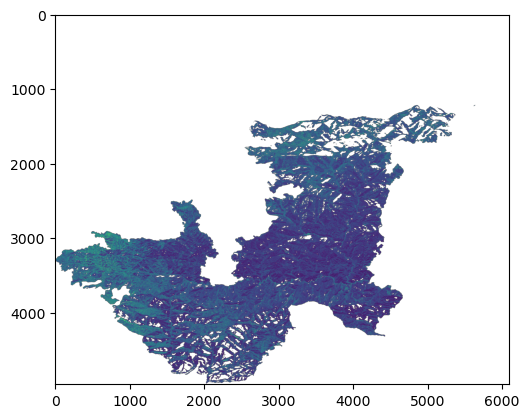

In [32]:
plt.imshow((alpha_south))

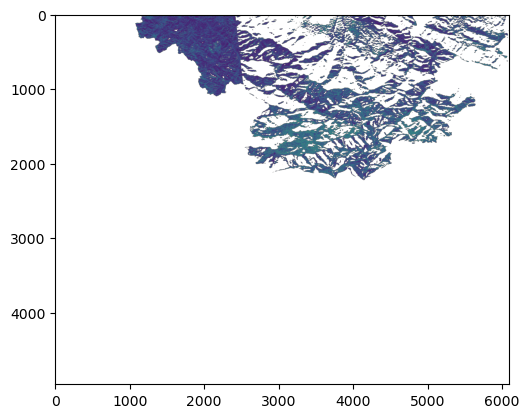

In [33]:
plt.imshow((alpha_north))  

In [34]:
print(alpha_north.shape)

(4963, 6093)


In [35]:
print(alpha_south.shape)

(4963, 6093)


In [36]:
post_alpha_merged = np.nanmean(np.stack([alpha_south, alpha_north]), axis=0)


/tmp/ipykernel_112686/1374029695.py:1: RuntimeWarning: Mean of empty slice
  post_alpha_merged = np.nanmean(np.stack([alpha_south, alpha_north]), axis=0)


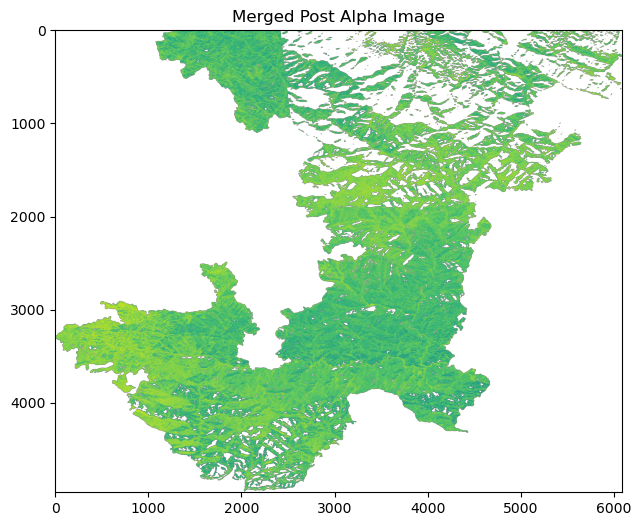

In [37]:
plt.figure(figsize=(10, 6))
plt.title("Merged Post Alpha Image")
plt.imshow(np.log10(post_alpha_merged))
#plt.colorbar(label='log10(backscatter)')
plt.show()


In [38]:


# ---- Save merged alpha to GeoTIFF ----
save_path = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/post_merged_alpha_image_test.tif"

# Use one of the inputs to copy geospatial metadata
with rasterio.open(output_path_0) as src:
    profile = src.profile

# Update profile for the merged image
profile.update({
    "height": post_alpha_merged.shape[0],
    "width": post_alpha_merged.shape[1],
    "count": 1,
    "dtype": post_alpha_merged.dtype,
    "compress": "lzw"
})

# Save merged Alpha raster
with rasterio.open(save_path, "w", **profile) as dst:
    dst.write(post_alpha_merged, 1)



In [39]:
import rasterio
import numpy as np

def print_tif_values(tif_path):
    """
    Print the numerical values and unique values in a TIF file.

    Parameters:
    tif_path (str): Path to the TIF file
    """
    try:
        # Open the TIF file
        with rasterio.open(tif_path) as src:
            # Print basic metadata
            print(f"TIF File: {tif_path}")
            print(f"Width: {src.width}, Height: {src.height}")
            print(f"Number of bands: {src.count}")
            print(f"Data type: {src.dtypes[0]}")

            # Read all bands
            for band_idx in range(1, src.count + 1):
                band_data = src.read(band_idx)

                print(f"\nBand {band_idx} data:")

                # If the array is too large, print a sample
                if band_data.size > 100:
                    print("Array is large, showing statistics and sample:")
                    print(f"Min: {np.nanmin(band_data)}, Max: {np.nanmax(band_data)}, Mean: {np.nanmean(band_data):.4f}, Median: {np.nanmedian(band_data):.4f}")
                    print("Sample of data (top-left corner):")
                    print(band_data[:5, :5])  # Show a 5x5 sample from the top left
                else:
                    # If the array is small enough, print all values
                    print(band_data)

                # Extract valid (non-NaN) values and round
                valid = band_data[~np.isnan(band_data)]
                if valid.size > 0:
                    unique_vals = np.unique(np.round(valid, 2))
                    print("Unique values (non-NaN, rounded to 2 decimals):")
                    print(unique_vals[:50])  # Show first 50 for brevity
                else:
                    print("No valid (non-NaN) values found in this band.")

    except Exception as e:
        print(f"Error reading TIF file: {e}")


# Call your function
tif_file_path = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/post_merged_alpha_image_test.tif"
print_tif_values(tif_file_path)


TIF File: /shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/post_merged_alpha_image_test.tif
Width: 6093, Height: 4963
Number of bands: 1
Data type: float64

Band 1 data:
Array is large, showing statistics and sample:
Min: 0.2354767248040481, Max: 89.94378553371595, Mean: 21.6379, Median: 18.7519
Sample of data (top-left corner):
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
Unique values (non-NaN, rounded to 2 decimals):
[0.24 0.27 0.29 0.31 0.33 0.34 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43
 0.44 0.47 0.48 0.5  0.52 0.54 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63
 0.65 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79
 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87]


In [40]:
# # === Save Postfire alpha1 ===
# post_alpha1_out_path = "/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Post_alpha_perimeter_data/post_merged_alpha_image_test_aligned.npy"
# np.save(post_alpha1_out_path, post_alpha_merged)